In [2]:
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [23]:
file1 = '/home/jovyan/Data/daily_pd5/Cleaned/pd_MX_2019_agg5_daily.csv'
df1 = pd.read_csv(file1)
df1 = df1.drop(columns=['grt', 'day', 'month'])
df1.columns = ['geohash_5', 'no_of_points', 'no_of_unique_users', 'local_date']
# df1.columns = ['geohash_5', 'no_of_points', 'no_of_unique_users', 'local_time', 'local_date']
df1 = df1[df1['local_date'].apply(lambda x: str(x).isdigit())]
df1['local_date'] = df1['local_date'].astype(int)
combined_df=df1

df1

,geohash_5,no_of_points,no_of_unique_users,local_date
0,d5f0q,2689,340,20190101
1,9fv76,73,18,20190101
2,9grqp,288,38,20190101
3,9g8w8,233,20,20190101
4,9gjy7,230,40,20190101
...,...,...,...,...
9580336,9g8vs,35,20,20191231
9580337,9v0mk,45,11,20191231
9580338,d58qk,75,10,20191231
9580339,9exhf,87,21,20191231


In [16]:
file2 = '/home/jovyan/Data/pd3/pd_mx2_2019_agg5_3h.csv'
df2 = pd.read_csv(file2)
# df1.columns = ['geohash_3', 'no_of_points', 'no_of_unique_users', 'local_date']
df2 = df2[df2['local_date'].apply(lambda x: str(x).isdigit())]
df2['local_date'] = df2['local_date'].astype(int)
df2

/tmp/ipykernel_198/1890030618.py:2: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(file2)


,geohash_5,no_of_points,no_of_unique_users,local_time,local_date
0,9emt3,88,17,20190701 00:00:00 - 03:00:00,20190701
1,9emu6,277,38,20190701 00:00:00 - 03:00:00,20190701
2,9emu7,37,12,20190701 00:00:00 - 03:00:00,20190701
3,9emu9,229,31,20190701 00:00:00 - 03:00:00,20190701
4,9emuc,351,75,20190701 00:00:00 - 03:00:00,20190701
...,...,...,...,...,...
3938554,d5f28,444,88,20191231 21:00:00 - 24:00:00,20191231
3938555,d5f2b,714,75,20191231 21:00:00 - 24:00:00,20191231
3938556,d5f2c,80,20,20191231 21:00:00 - 24:00:00,20191231
3938557,d5f2f,70,21,20191231 21:00:00 - 24:00:00,20191231


In [22]:
combined_df = pd.concat([df1, df2], ignore_index=True)
combined_df

,geohash_5,no_of_points,no_of_unique_users,local_time,local_date
0,9emgx,271,17,20190101 00:00:00 - 03:00:00,20190101
1,9emsz,250,14,20190101 00:00:00 - 03:00:00,20190101
2,9emt1,320,23,20190101 00:00:00 - 03:00:00,20190101
3,9emt3,720,78,20190101 00:00:00 - 03:00:00,20190101
4,9emtk,136,28,20190101 00:00:00 - 03:00:00,20190101
...,...,...,...,...,...
9030821,d5f28,444,88,20191231 21:00:00 - 24:00:00,20191231
9030822,d5f2b,714,75,20191231 21:00:00 - 24:00:00,20191231
9030823,d5f2c,80,20,20191231 21:00:00 - 24:00:00,20191231
9030824,d5f2f,70,21,20191231 21:00:00 - 24:00:00,20191231


In [3]:
# Parse the original datetime string and adjust the time
df1['local_time'] = pd.to_datetime(df1['local_time'], format='%Y%m%d %H:%M:%S')
df1['local_time'] = df1['local_time'].dt.strftime('%Y%m%d %H:%M:%S') + ' - ' + (df1['local_time'] + pd.Timedelta(hours=3)).dt.strftime('%H:%M:%S')

df1

ValueError: time data "20190701 00:00:00 - 03:00:00" at position 0 doesn't match format specified

In [20]:
# import os
# import pandas as pd

# # Specify the folder containing the files
# folder_path = '/home/jovyan/Data/Fixing'

# # Get a list of all files in the folder
# file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# # Initialize an empty DataFrame
# combined_df = pd.DataFrame()

# # Define the new column names
# new_columns = ['geohash_3', 'no_of_points', 'no_of_unique_users', 'local_date']

# # Loop through all files and append their content to the combined DataFrame
# for file in file_list:
#     file_path = os.path.join(folder_path, file)
#     df = pd.read_csv(file_path)
#     df.columns = new_columns  # Rename columns
#     combined_df = pd.concat([combined_df, df], ignore_index=True)

# combined_df

,geohash_3,no_of_points,no_of_unique_users,local_date
0,tgt,162348,2925,20190522
1,tgv,62093,985,20190522
2,tuj,189563,3555,20190522
3,tum,60512,1328,20190522
4,tut,103758,1879,20190522
...,...,...,...,...
1970,whe,10293,246,20190527
1971,whf,18868,444,20190527
1972,whg,60898,1412,20190527
1973,whu,8681,235,20190527


# Check duplicates

In [24]:
# combined_df['geohash_3'] = combined_df['geohash_3'].astype(str)
combined_df['geohash_5'] = combined_df['geohash_5'].astype(str)

combined_df['no_of_points'] = combined_df['no_of_points'].astype(int)
combined_df['no_of_unique_users'] = combined_df['no_of_unique_users'].astype(int)
# combined_df['local_time'] = combined_df['local_time'].astype(str)
combined_df['local_date'] = combined_df['local_date'].astype(int)

combined_df = combined_df.drop_duplicates()
combined_df

,geohash_5,no_of_points,no_of_unique_users,local_date
0,d5f0q,2689,340,20190101
1,9fv76,73,18,20190101
2,9grqp,288,38,20190101
3,9g8w8,233,20,20190101
4,9gjy7,230,40,20190101
...,...,...,...,...
9580336,9g8vs,35,20,20191231
9580337,9v0mk,45,11,20191231
9580338,d58qk,75,10,20191231
9580339,9exhf,87,21,20191231


# Check missing dates

In [25]:
unique_values_count = combined_df["local_date"].unique()
all_dates = pd.date_range(start='2019-01-01', end='2019-12-31').strftime('%Y%m%d').astype(int)
all_dates = np.array(all_dates)
missing_dates = np.setdiff1d(all_dates, unique_values_count)

missing_dates

array([], dtype=int64)

# Check for hours per day (for 3h)

In [25]:
# Convert local_date to datetime objects
combined_df['local_date'] = pd.to_datetime(combined_df['local_date'], format='%Y%m%d')

# Function to parse the local_time column and extract the start hour
def parse_start_hour(time_str):
    try:
        start_time_str, _ = time_str.split(' - ')
        start_time = datetime.strptime(start_time_str, '%Y%m%d %H:%M:%S')
        return start_time.hour
    except ValueError:
        return None

combined_df['start_hour'] = combined_df['local_time'].map(parse_start_hour)

# Required hours to check
required_hours = set([0, 3, 6, 9, 12, 15, 18, 21])

# Group by local_date and check missing hours
missing_hours = {}

for date, group in combined_df.groupby('local_date'):
    present_hours = set(group['start_hour'])
    missing = required_hours - present_hours
    if missing:
        missing_hours[date] = sorted(list(missing))

# Convert missing hours dictionary to DataFrame for better readability
missing_hours_df = pd.DataFrame(list(missing_hours.items()), columns=['Date', 'Missing Hours'])

# Display the missing hours
print("Missing hours for each date:")
print(missing_hours_df)


/tmp/ipykernel_198/1032260670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['local_date'] = pd.to_datetime(combined_df['local_date'], format='%Y%m%d')
/tmp/ipykernel_198/1032260670.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['start_hour'] = combined_df['local_time'].map(parse_start_hour)


Missing hours for each date:
Empty DataFrame
Columns: [Date, Missing Hours]
Index: []


# Check with figure

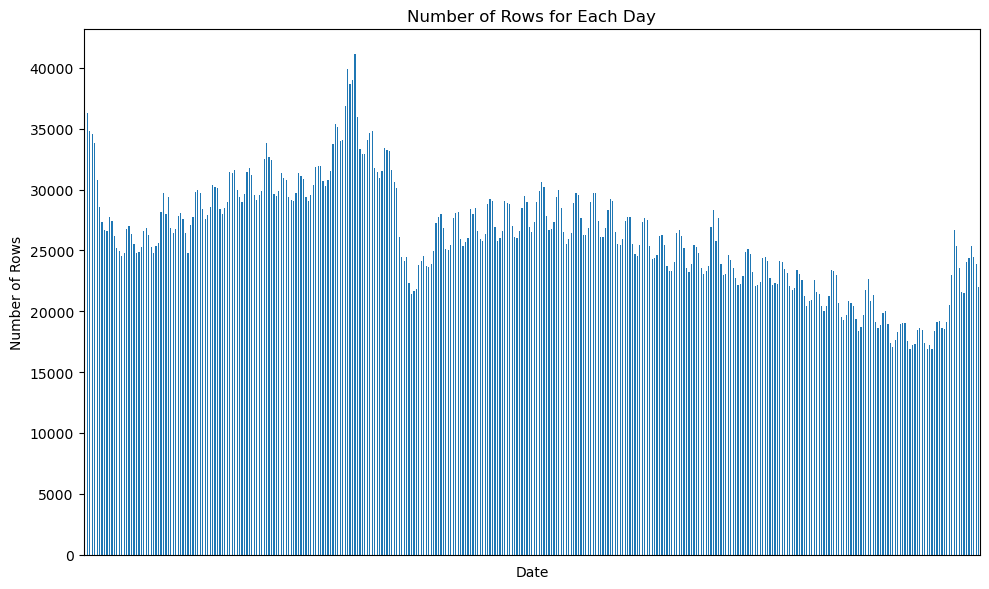

In [26]:
daily_counts = combined_df['local_date'].value_counts().sort_index()

# Generate custom xticks starting from the first date and then incrementing by 7 days
start_date = daily_counts.index.min()
end_date = daily_counts.index.max()
custom_xticks = pd.date_range(start=start_date, end=end_date, freq='7D')

# Plot the results
plt.figure(figsize=(10, 6))
daily_counts.plot(kind='bar')
plt.title('Number of Rows for Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Rows')
# plt.xticks(ticks=range(len(daily_counts)), labels=daily_counts.index.strftime('%Y-%m-%d'), rotation=90)
plt.gca().set_xticks([i for i, date in enumerate(daily_counts.index) if date in custom_xticks])
plt.tight_layout()
plt.show()

# Check Minimum and Maximum

In [13]:
max_15_counts = daily_counts.nlargest(15)
max_15_counts

20191020    25676
20191019    25354
20191013    24927
20191012    24473
20191010    24267
20191018    24243
20190606    24035
20191015    24024
20191017    24002
20190915    23989
20191021    23961
20191016    23950
20190929    23924
20190608    23895
20191011    23849
Name: local_date, dtype: int64

In [14]:
min_5_counts = daily_counts.nsmallest(15)
min_5_counts

20191212    6517
20191211    6557
20191203    6599
20191127    6637
20191210    6639
20191202    6655
20191205    6666
20191209    6669
20191204    6705
20191126    6712
20191216    6760
20191128    6799
20191217    6841
20191213    6990
20191206    6995
Name: local_date, dtype: int64

# Export

In [12]:
# Clean up
combined_df['local_date'] = combined_df['local_date'].dt.strftime('%Y%m%d').astype(int)
combined_df = combined_df.sort_values('local_date').reset_index(drop = True)
combined_df

/tmp/ipykernel_198/829992120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['local_date'] = combined_df['local_date'].dt.strftime('%Y%m%d').astype(int)


,geohash_3,no_of_points,no_of_unique_users,local_time,local_date,start_hour
0,9em,10820,772,20190101 00:00:00 - 03:00:00,20190101,0
1,9gb,64167,3824,20190101 15:00:00 - 18:00:00,20190101,15
2,9gc,17378,1103,20190101 15:00:00 - 18:00:00,20190101,15
3,9gd,46142,3105,20190101 15:00:00 - 18:00:00,20190101,15
4,9ge,4257,351,20190101 15:00:00 - 18:00:00,20190101,15
...,...,...,...,...,...,...
350401,9u0,1284,191,20191231 06:00:00 - 09:00:00,20191231,6
350402,9u1,2956,345,20191231 06:00:00 - 09:00:00,20191231,6
350403,9u2,999,100,20191231 06:00:00 - 09:00:00,20191231,6
350404,9t6,531,36,20191231 06:00:00 - 09:00:00,20191231,6


In [21]:
combined_df

,geohash_5,no_of_points,no_of_unique_users,local_date
0,tef4g,36,10,20190101
1,te7gv,536,45,20190101
2,tue7t,186,19,20190101
3,t9y34,132,23,20190101
4,teg78,138,15,20190101
...,...,...,...,...
13590432,ttt9y,77,14,20191231
13590433,tumzd,144,16,20191231
13590434,teezh,87,22,20191231
13590435,tszw2,35,10,20191231


In [22]:
# Save the combined DataFrame to a new CSV file
folder_path = '/home/jovyan/Data/daily_pd5/Cleaned/'
combined_df.to_csv(folder_path + 'pd_IN_2019_agg5_daily.csv', index=False)

# Check All Number (for R Kept Figure)

In [1]:
%reload_ext sql
%config SqlMagic.autocommit=False
%config SqlMagic.autolimit=0
%config SqlMagic.autopandas=True
%config SqlMagic.displaylimit=200

In [2]:
%sql trino://localhost:9090/cuebiq/

'Connected: @cuebiq/'

In [3]:
import os
import time
# import geohash
import logging
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
from sqlalchemy import create_engine

In [4]:
# SQL engine
from trino.dbapi import connect 
from sqlalchemy import create_engine
import pandas as pd
import time

class TrinoEngine():
    def __init__(self):
        conn = connect(
            host="localhost",
            port=9090,
            catalog="cuebiq"
        )
        self.cur = conn.cursor()
        self.engine = create_engine("trino://localhost:9090/cuebiq/")
    
    def execute_statement(self, query:str) -> list:
        """
        Create and drop statements.
        """
        self.cur.execute(query)
        return self.cur.fetchall()
    
    def read_sql(self, query:str) -> pd.DataFrame: 
        """
        Select and insert into operations.
        """
        return pd.read_sql(query, self.engine)

sql_engine = TrinoEngine()

In [5]:
schema_name = {'cda': 'cuebiq.paas_cda_pe_v3'}
pe_dl_table = f"{schema_name['cda']}.device_location_uplevelled"

In [6]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [8]:
# country_code = 'MX'
# country_code = 'IN'
# country_code = 'ID'
country_code = 'CO'

In [11]:
pe_dl = sql_engine.read_sql(
    f"""
    SELECT 
        COUNT(*) AS total_no_of_points,
        COUNT(DISTINCT(cuebiq_id)) AS total_no_of_unique_users
    FROM {pe_dl_table}
    WHERE 
        country_code = '{country_code}' 
        AND event_zoned_datetime IS NOT NULL
        AND TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s')) IS NOT NULL
        -- AND DATE(TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) BETWEEN date_parse('20191101', '%Y%m%d') AND date_parse('20191231', '%Y%m%d')
        AND DATE(TRY(date_parse(substr(event_zoned_datetime, 1, 19), '%Y-%m-%dT%H:%i:%s'))) BETWEEN date_parse('20200101', '%Y%m%d') AND date_parse('20201231', '%Y%m%d')
        AND lat <> 0
        AND lng <> 0
    """
)
pe_dl

,total_no_of_points,total_no_of_unique_users
0,338744689,201672


 2019 (total_no_of_points total_no_of_unique_users)  2020  
CO: 126379332, 193424, 338744689, 201672
